In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline
import time

In [2]:
csvf = "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv"
df = pd.read_csv(csvf, header=None, error_bad_lines=False)
print(df.shape)
df.head()

(303, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [18]:
# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

In [19]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

In [20]:
# Calculate predicted values.
start = time.time()
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)
print("Kmeans",time.time() - start)

Kmeans 0.04587697982788086


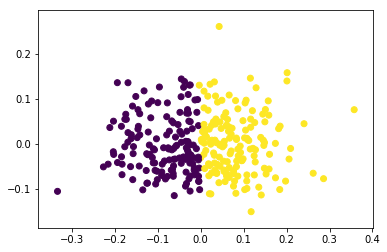

Comparing k-means clusters against the data:


col_0,0,1
row_0,,
0,84,65
1,55,99


In [21]:
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
display(pd.crosstab(y_pred, y))

In [22]:
#Now let's try MiniBatch:

In [23]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
start = time.time()
predict_mini = minibatchkmeans.predict(X_pca)
print(time.time() - start)
# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
display(pd.crosstab(predict_mini, y_pred))

0.0009975433349609375
Comparing k-means and mini batch k-means solutions:


col_0,0,1
row_0,,
0,0,144
1,149,10


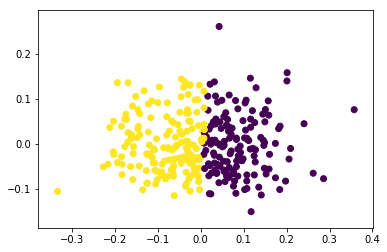

In [24]:
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict_mini)
plt.show()

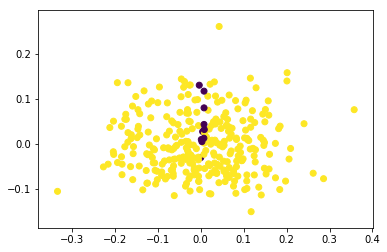

In [25]:
#Just to understand what we've just done, below I chart 2 colors: cases where kmeans and minibatch
#predicted the same, and cases where they didn't. Besides the sliver in the middle, these methods
# are mostly the same

dfs = pd.DataFrame({'ypred':y_pred, 'mini':predict_mini, 'true':y})
dfs['difference'] = np.where(dfs.ypred == dfs.mini, 0,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dfs.difference)
plt.show()

## Drill: More clusters?

Your task is to take the $k$-means code here and see what happens when you change the value of $k$.  What solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor.  Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

In [26]:
#Start by seeing which features correlate most with the target variable. yes, I know this isn't
#Really unsupervised learning doing it this way...

In [27]:
df.corr()[13]

0     0.222853
1     0.224469
2     0.407075
3     0.157754
4     0.070909
5     0.059186
6     0.183696
7    -0.415040
8     0.397057
9     0.504092
10    0.377957
13    1.000000
Name: 13, dtype: float64

In [29]:
#Function to do both minibatch kmeans and full kmeans on any given x array
def check(x,n=2):
    y_pred = KMeans(n_clusters=n).fit_predict(x)
    minibatchkmeans = MiniBatchKMeans(init='random', n_clusters=n, batch_size=200)
    minibatchkmeans.fit(x)
    predict_mini = minibatchkmeans.predict(x)
    dfs = pd.DataFrame({'ypred':y_pred, 'mini':predict_mini, 'true':y})
    display(pd.crosstab(dfs.true, dfs.ypred))
    display(pd.crosstab(dfs.true, dfs.mini))    

In [51]:
#try the features with the highest correlations to 13
x = normalize(df[[2,7,8,9,10]])
check(x)

ypred,0,1
true,,
0,56,83
1,149,15


mini,0,1
true,,
0,56,83
1,149,15


In [52]:
#Not bad, not great. 
# Reduce it to two components for graphing
X_pca = PCA(2).fit_transform(x)

check(X_pca)

ypred,0,1
true,,
0,55,84
1,149,15


mini,0,1
true,,
0,80,59
1,13,151


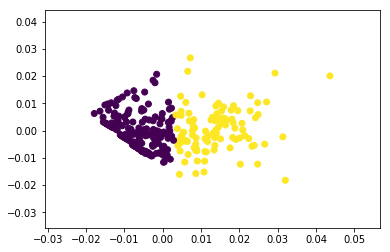

In [53]:
y_pred = KMeans(n_clusters=2).fit_predict(X_pca)
plt.scatter([c[0] for c in X_pca],[c[1] for c in X_pca], c=y_pred)
plt.show()

ypred,0,1,2
true,,,
0,20,59,60
1,102,9,53


mini,0,1,2
true,,,
0,52,37,50
1,39,123,2


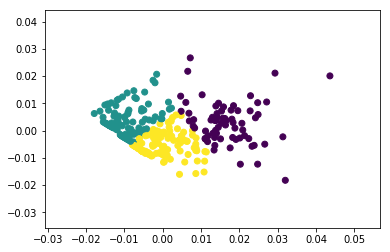

In [54]:
# Not great, our clusters don't have even variance. Let's see what 3 clusters do
X_pca = PCA(2).fit_transform(x)
#try with n = 3
check(X_pca, n=3)
y_pred = KMeans(n_clusters=3).fit_predict(X_pca)
plt.scatter([c[0] for c in X_pca],[c[1] for c in X_pca], c=y_pred)
plt.show()

ypred,0,1,2,3
true,,,,
0,55,14,53,17
1,43,94,4,23


mini,0,1,2,3
true,,,,
0,50,50,22,17
1,2,30,108,24


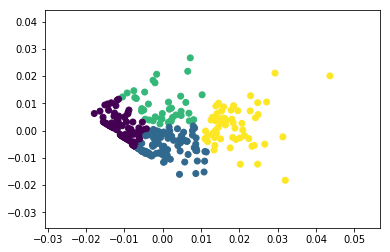

In [55]:
#and four...
check(X_pca, n=4)
y_pred = KMeans(n_clusters=4).fit_predict(X_pca)
plt.scatter([c[0] for c in X_pca],[c[1] for c in X_pca], c=y_pred)
plt.show()

In [56]:
#By treating clustesr 0 and 1 as True and 2-3 as false, we are getting just-ok results

passed on 0 0


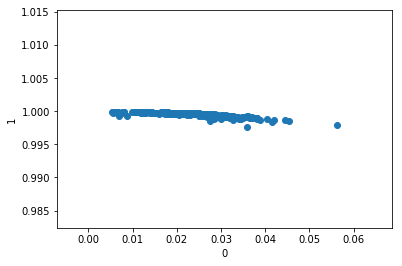

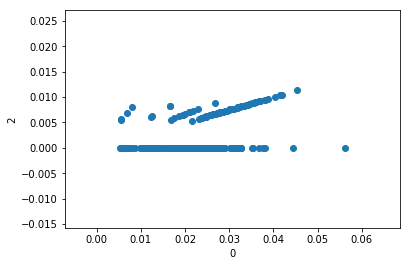

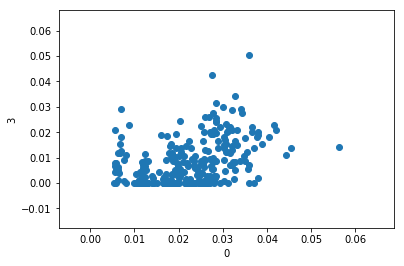

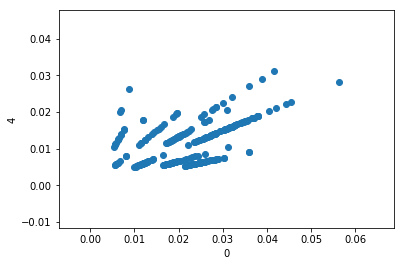

passed on 1 0
passed on 1 1


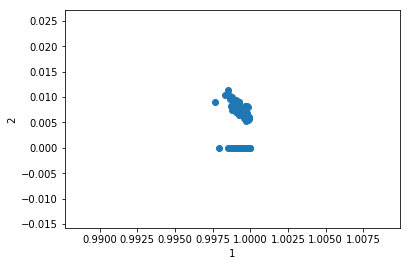

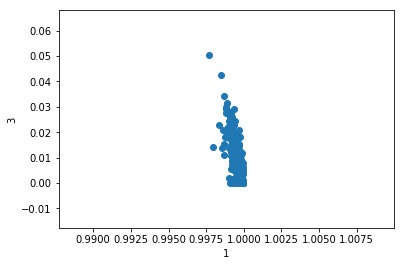

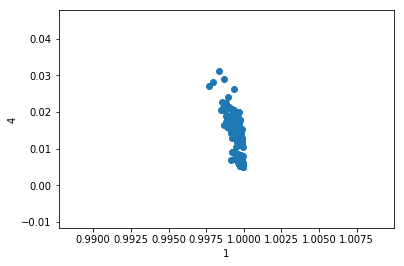

passed on 2 0
passed on 2 1
passed on 2 2


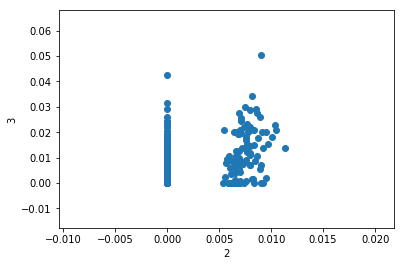

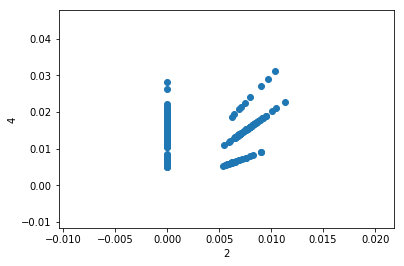

passed on 3 0
passed on 3 1
passed on 3 2
passed on 3 3


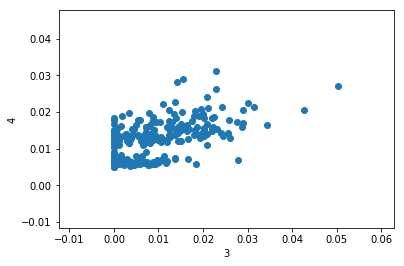

passed on 4 0
passed on 4 1
passed on 4 2
passed on 4 3
passed on 4 4


In [57]:
#Loop through the feature combinations to see if any seem to create clear clusters
for i in range(5):
    for j in range(5):
        if i>=j:
            print('passed on',i,j)
        else:
            plt.scatter([c[i] for c in x], [c[j] for c in x])
            plt.xlabel(i)
            plt.ylabel(j)
            plt.show()

In [58]:
#combinations that look interesting: 0-3, 2-3, 4-3

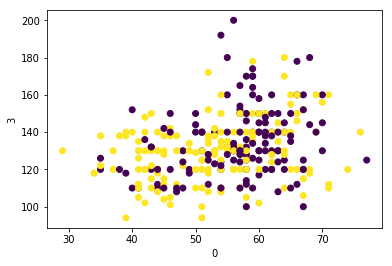

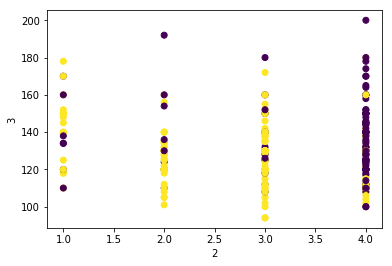

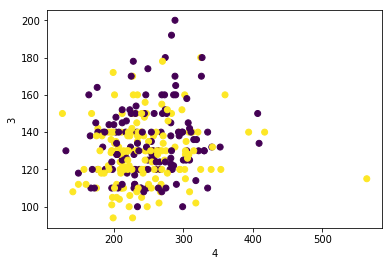

In [59]:
#Now let's check if those clusters actually differentiate the target variable
for i in [0,2,4]:
    plt.scatter(df[i], df[3],c =y)
    plt.xlabel(i)
    plt.ylabel(3)
    plt.show()

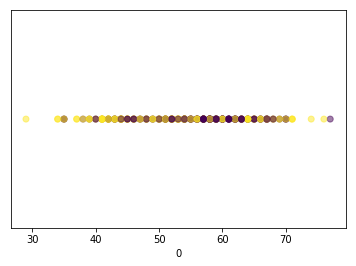

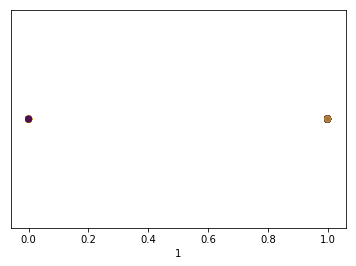

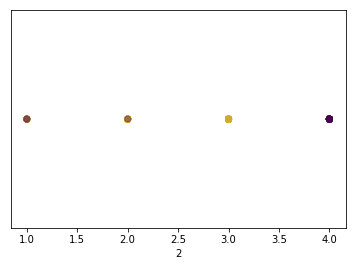

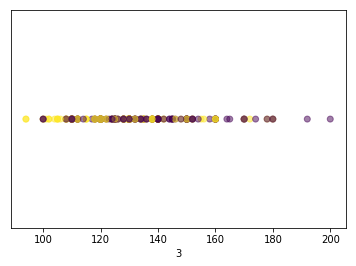

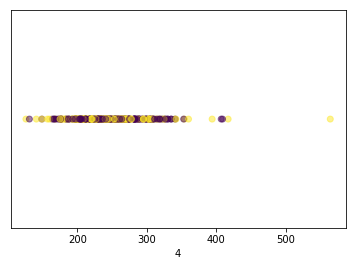

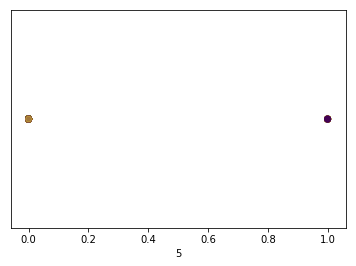

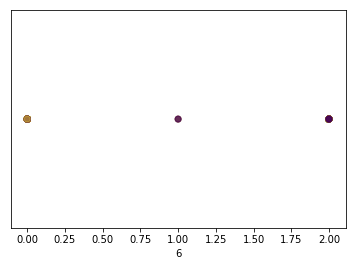

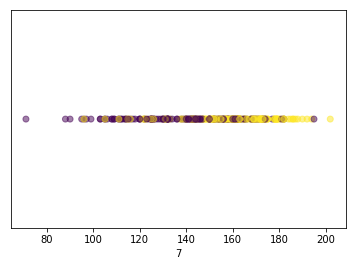

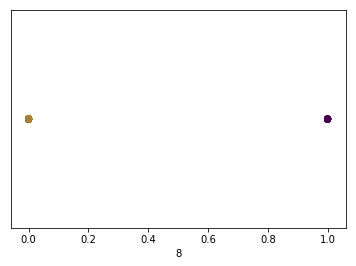

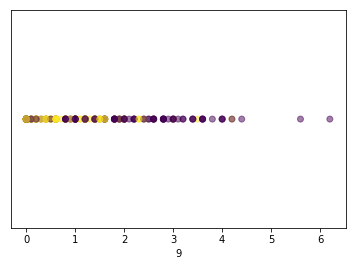

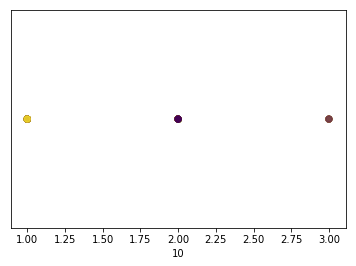

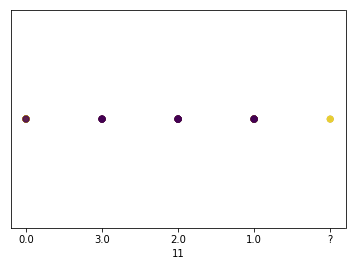

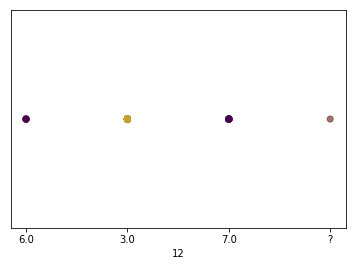

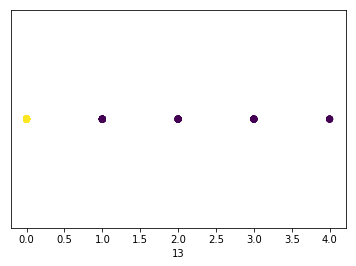

In [60]:
#that isn't helping. What about examing each feature as a numberline?
for i in df.columns:
    plt.scatter(df[i], [0 for _ in df[i]], c=y,alpha=.5)
    plt.xlabel(i)
    plt.yticks([])
    plt.show()

In [61]:
#Based on the above analyses I will try these features:
x = normalize(df[[3,8,7,9,10]])
check(x)

ypred,0,1
true,,
0,73,66
1,30,134


mini,0,1
true,,
0,73,66
1,30,134


In [62]:
#What a mess
check(x,n=3)

ypred,0,1,2
true,,,
0,46,27,66
1,17,87,60


mini,0,1,2
true,,,
0,68,25,46
1,64,81,19


In [68]:
xpca = PCA(2).fit_transform(df[[3,8,7,9,10]])

ypred,0,1
true,,
0,53,86
1,129,35


mini,0,1
true,,
0,65,74
1,135,29


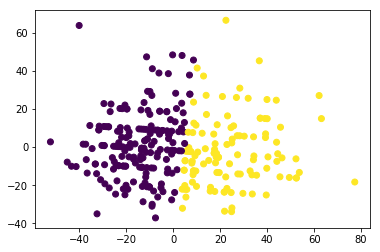

In [69]:
check(xpca)

y_pred = KMeans(n_clusters=2).fit_predict(xpca)
plt.scatter([c[0] for c in xpca],[c[1] for c in xpca], c=y_pred)
plt.show()

ypred,0,1,2
true,,,
0,37,66,36
1,39,24,101


mini,0,1,2
true,,,
0,44,35,60
1,26,106,32


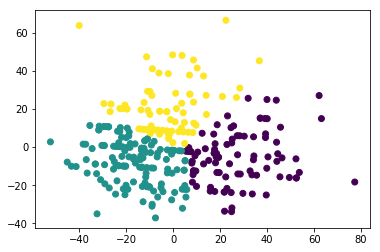

In [71]:
check(xpca,n=3)
y_pred = KMeans(n_clusters=3).fit_predict(xpca)
plt.scatter([c[0] for c in xpca],[c[1] for c in xpca], c=y_pred)
plt.show()

ypred,0,1,2,3
true,,,,
0,32,25,38,44
1,39,80,8,37


mini,0,1,2,3
true,,,,
0,32,36,46,25
1,35,35,13,81


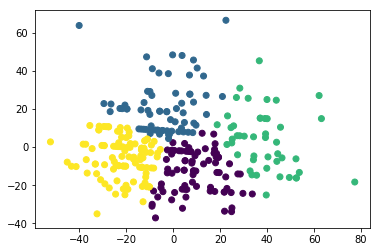

In [72]:
check(xpca,n=4)
y_pred = KMeans(n_clusters=4).fit_predict(xpca)
plt.scatter([c[0] for c in xpca],[c[1] for c in xpca], c=y_pred)
plt.show()